# WIP

Playing with a different way of doing exploration - WIP

In [1]:
import random
import gym
import numpy as np
from collections import deque

import torch
from torch import nn, optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ENV_NAME = "LunarLander-v2"

GAMMA = 0.999
LEARNING_RATE = 0.001

MEMORY_SIZE = 25000
BATCH_SIZE = 32

CLIP = 0.01

# EXPLORATION_MAX = 0.3
# EXPLORATION_MIN = 0.2
# EXPLORATION_DECAY = 0.9999

In [4]:
class EnvModel(nn.Module):
    def __init__(self, observation_space, action_space):
        super().__init__()
        self.fc1 = nn.Linear(observation_space, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_out = nn.Linear(64, action_space)
    
    def forward(self, x):
        x = torch.from_numpy(x).float()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_out(x)
        return x

In [39]:
class Dqn():
    def __init__(self, observation_space, action_space):
        self.observation_space = observation_space
        self.action_space = action_space
        self.model = EnvModel(observation_space, action_space)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.train_losses = []
        self.memory = deque(maxlen=MEMORY_SIZE)    
        
        
    def fit(self, state, q_values):
        q_values = torch.FloatTensor(q_values)
        self.optimizer.zero_grad()
        log_ps = self.model(state)
        loss = self.criterion(log_ps, q_values)
        loss.backward()
        self.optimizer.step()
        
        
    def softmax(x):
        return F.softmax(x)
        
    def predict(self, state):
        self.model.eval()
        with torch.no_grad():
            prediction = self.model(state)
        
        self.model.train()
        return prediction.numpy()
    
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
        
    def get_action(self, state):
        q_values = self.predict(state)
        q_probs = np.exp(q_values)/sum(np.exp(q_values))
        q_clipped = np.clip(q_probs, CLIP, 1 - CLIP)
        
        q_clipped = q_clipped / q_clipped.sum(axis=0,keepdims=1)
        
        return np.random.choice([0, 1, 2, 3], p=q_clipped)
    
    
    def experience_replay(self):
        batch = random.sample(self.memory, min(BATCH_SIZE, len(self.memory)))

        for state, action, reward, state_next, terminal in batch:
            state_reward = reward if terminal else (reward + GAMMA * np.max(self.predict(state_next)))
            q_values_predicted = self.predict(state)
            q_values_predicted[action] = state_reward
            self.fit(state, q_values_predicted)

In [40]:
env = gym.make(ENV_NAME)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/Users/hamishdickson/miniconda3/envs/py36/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [41]:
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

print(observation_space, action_space)

8 4


In [42]:
epochs = 250

scores = []
final_rewards = []

dqn = Dqn(observation_space, action_space)

landed_count = 0

In [43]:
%%time

for run in range(epochs):
    step = 0
    state = env.reset()

    while True:
        step += 1
        action = dqn.get_action(state)
        
        state_next, reward, terminal, info = env.step(action)
        
        if terminal and reward >= 50:
            print("landed: " + str(reward))
            landed_count += 1
        
        dqn.remember(state, action, reward, state_next, terminal)
        
        state = state_next
        
        if terminal:
            print("Epoch: " + str(run + 1) + ", steps: " + str(step) + ", reward: " + str(reward))
            scores.append(step)
            final_rewards.append(reward)
            break
            
        dqn.experience_replay()

/Users/hamishdickson/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/Users/hamishdickson/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in less


Epoch: 1, steps: 114, reward: -100
Epoch: 2, steps: 82, reward: -100
Epoch: 3, steps: 75, reward: -100
Epoch: 4, steps: 72, reward: -100
Epoch: 5, steps: 76, reward: -100
Epoch: 6, steps: 55, reward: -100
Epoch: 7, steps: 83, reward: -100
Epoch: 8, steps: 63, reward: -100
Epoch: 9, steps: 54, reward: -100
Epoch: 10, steps: 69, reward: -100
Epoch: 11, steps: 68, reward: -100
Epoch: 12, steps: 71, reward: -100
Epoch: 13, steps: 59, reward: -100
Epoch: 14, steps: 81, reward: -100
Epoch: 15, steps: 60, reward: -100
Epoch: 16, steps: 74, reward: -100
Epoch: 17, steps: 87, reward: -100
Epoch: 18, steps: 52, reward: -100
Epoch: 19, steps: 76, reward: -100
Epoch: 20, steps: 68, reward: -100
Epoch: 21, steps: 106, reward: -100
Epoch: 22, steps: 93, reward: -100
Epoch: 23, steps: 69, reward: -100
Epoch: 24, steps: 66, reward: -100
Epoch: 25, steps: 66, reward: -100
Epoch: 26, steps: 79, reward: -100
Epoch: 27, steps: 56, reward: -100
Epoch: 28, steps: 68, reward: -100
Epoch: 29, steps: 79, rewar

Epoch: 232, steps: 86, reward: -100
Epoch: 233, steps: 75, reward: -100
Epoch: 234, steps: 89, reward: -100
Epoch: 235, steps: 73, reward: -100


KeyboardInterrupt: 

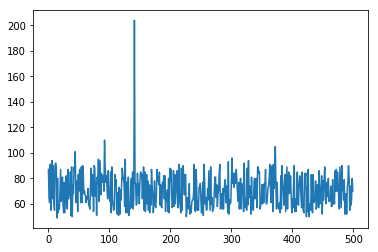

In [22]:
plt.plot(scores)

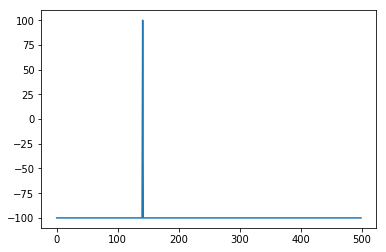

In [23]:
plt.plot(final_rewards)

In [ ]:
# this breaks the kernel


from gym.wrappers import Monitor

video_env = Monitor(env, './test_video', force=True)

state = video_env.reset()
done = False
while not done:
#     video_env.render()
#     video_env.render(close=True)
    action = np.argmax(dqn.predict(state))
    state, reward, done, info = video_env.step(action)
#     print(reward)